### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [ ]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [ ]:
print(list(labels.items())[:5])

### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

In [4]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x)

Variable containing:
-1.2441  1.1853  2.1389  ...  -1.4262 -0.2089  1.1423
-1.1155  1.0940  2.1407  ...  -2.0141 -0.6414  1.4541
-1.4551  0.7487  1.3078  ...  -1.6951 -0.4984  2.0127
-1.2710  1.1054  1.8119  ...  -1.7592 -0.6359  1.3758
-1.2959  1.1080  2.0929  ...  -1.8823 -0.6039  1.2794
[torch.FloatTensor of size 5x1000]

### Predict class probabilities

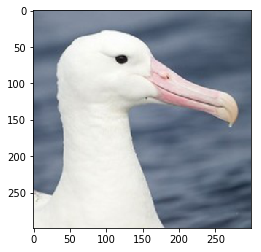

top-10 classes are: 
 [prob : class label]
0.9747 :	albatross
0.0026 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	hammerhead
0.0003 :	drake
0.0003 :	nipple
0.0003 :	Polaroid camera


In [5]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



### Having fun with pre-trained nets

In [6]:
import os.path
if not os.path.isfile('img.jpg'):
    !curl http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -o img.jpg
else:
    print("Img already downloaded")

Img already downloaded


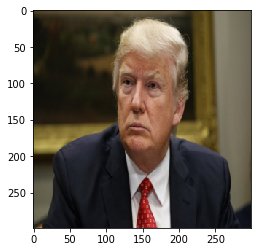

top-10 classes are: 
 [prob : class label]
0.7468 :	suit
0.0806 :	Windsor tie
0.0379 :	groom
0.0042 :	Loafer
0.0035 :	oboe
0.0030 :	academic gown
0.0022 :	wig
0.0020 :	bow tie
0.0019 :	Sussex spaniel


In [13]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [7]:
import os
if not os.path.isfile('data.zip'):
    !wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
    !unzip data.zip
else:
    print("Data already downloaded")

Data already downloaded


### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [8]:
from copy import deepcopy  # in case you still need original model
from IPython.core.debugger import set_trace

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
#         set_trace()
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

for param in embedding.parameters():
    param.requires_grad = False # the memory blows up if we don't do this as the layers remember all gradients

assert embedding(img).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [16]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))


                        labels:  36.1KiB
                      Identity:   1.2KiB
                      Variable:   1.0KiB
               NamespaceMagics:   888.0B
                            _i:   699.0B
                           _i6:   699.0B
                          _i15:   699.0B
                           _i3:   594.0B
                          _i11:   594.0B
                          _i16:   578.0B


In [13]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imread, imresize
import os

X = []
Y = []

batch_size = 128
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):

    y = fname.startswith("cat") # cat is true, dog is false
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
#         set_trace()
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2])))
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor)
        
        X.append(features.data.numpy())
        
        batch_index = 0
        continue
        
    batch_index += 1

  1%|          | 126/25000 [00:01<04:13, 98.06it/s]

KeyboardInterrupt: 

In [9]:
import numpy as np
import h5py
import os

if not os.path.isfile('cat_vs_dog.h5'):
    X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
    assert X.ndim == 2
    #WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

    #crop if we ended prematurely
    Y = np.array(Y[:len(X)])

    print(X.shape, Y.shape)

    # save the data
    with h5py.File('cat_vs_dog.h5', 'w') as hf:
        hf.create_dataset("cat_vs_dog_X",  data=X)
        hf.create_dataset("cat_vs_dog_Y",  data=Y)
else:
    # load the data
    with h5py.File('cat_vs_dog.h5', 'r') as hf:
        X = hf['cat_vs_dog_X'][:]
        Y = hf['cat_vs_dog_Y'][:]
    print(X.shape, Y.shape)

(24960, 2048) (24960,)


In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test, train_idx, test_idx = train_test_split(X, Y, range(X.shape[0]), test_size=0.2)
X_train, X_val, Y_train, Y_val, train_idx, val_idx = train_test_split(X_train, Y_train, train_idx,test_size=0.25)

assert(np.all(X[test_idx]==X_test), np.all(X[train_idx]==X_train), np.all(X[val_idx]==X_val))
X_train.shape, X_val.shape, X_test.shape

/home/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((14976, 2048), (4992, 2048), (4992, 2048))

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [16]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [17]:
clf_svm=SVC(C=1, gamma='auto', kernel='rbf')
clf_svm.fit(X_train,Y_train)
clf_svm.score(X_val, Y_val)

0.9889823717948718

In [18]:
clf_rf=RandomForestClassifier(n_estimators=30)
clf_rf.fit(X_train, Y_train)
clf_rf.score(X_val, Y_val)

0.9789663461538461

In [19]:
clf_logreg=LogisticRegression(C=1.0)
clf_logreg.fit(X_train, Y_train)
clf_logreg.score(X_val, Y_val)

0.984375

In [20]:
clf_rf.score(X_test, Y_test),clf_logreg.score(X_test, Y_test),clf_svm.score(X_test, Y_test)

(0.9813701923076923, 0.9875801282051282, 0.9887820512820513)

The 2048-vector taken from InceptionV3 seems great for classifying cats vs dogs

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [11]:
import time
import copy

def train_model(model, dset, criterion, optimizer, num_epochs, lr_scheduler=None, use_gpu=False):
    since = time.time()
    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler :
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset['loaders'][phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1) # _ is the value - we don't need it
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset['sizes'][phase]
            epoch_acc = running_corrects / dset['sizes'][phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("Saving new best model")
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [56]:
tr = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.IntTensor(Y_train.astype(int)))
tr_loader = torch.utils.data.DataLoader(tr, batch_size=64, shuffle=False)
val = torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val.astype(int)))
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=False)

dataset = {}
dataset['loaders']={}
dataset['loaders']['train'] = tr_loader
dataset['loaders']['val'] = val_loader
dataset['sizes']={}
dataset['sizes']['train'] = X_train.shape[0]
dataset['sizes']['val'] = X_val.shape[0]


In [13]:
import torch
import torch.nn as nn

model_head = nn.Sequential()
# dense "head"
model_head.add_module('dense1', nn.Linear(2048, 1000))
model_head.add_module('dense1_bn', nn.BatchNorm1d(1000))
model_head.add_module('dense1_relu', nn.ReLU())

model_head.add_module('dense2', nn.Linear(1000, 100))
model_head.add_module('dense2_bn', nn.BatchNorm1d(100))
model_head.add_module('dense2_relu', nn.ReLU())

model_head.add_module('final_dropout', nn.Dropout(p=0.1))
model_head.add_module('final_logits', nn.Linear(100, 2))  # logits for 2 classes - cats vs dogs

### Train the head

In [58]:
optimizer = torch.optim.Adam(model_head.parameters())
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
criterion = nn.CrossEntropyLoss()
trained = train_model(model_head, dataset, criterion, optimizer, 25) 

Epoch 0/24
----------
> <ipython-input-55-273f88972f55>(43)train_model()
     41                 _, preds = torch.max(outputs.data, 1) # _ is the value - we don't need it
     42                 set_trace()
---> 43                 loss = criterion(outputs, labels)
     44 
     45                 # backward + optimize only if in training phase

ipdb> labels
Variable containing:
 1
 0
 1
 1
 1
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
 1
 0
 0
 0
 1
 0
 1
 1
 0
 1
 0
 0
 0
 1
 0
 1
 0
 0
 0
 0
 1
 0
 0
 1
 0
 1
 1
 0
 1
 0
 1
 1
 0
 0
 1
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 1
 1
 0
 0
[torch.LongTensor of size 64]

ipdb> outputs
Variable containing:
 0.6281 -0.1648
 0.2269 -0.0801
 0.1577 -0.4151
 0.3704 -0.1079
 0.2665 -0.1577
 0.2714 -0.3789
-0.1493 -0.2161
 0.2026 -0.3090
 0.1941 -0.3357
 0.2055 -0.2140
 0.3028 -0.1449
 0.2900 -0.4162
 0.3872 -0.6957
 0.3607 -0.3552
 0.4314 -0.0500
 0.3380  0.0201
 0.2182 -0.2619
 0.3370  0.0398
 0.3882  0.0243
 0.1219 -0.4448
 0.3106 -0.2980
 0.2994 -0.1778
 0.0857 -

BdbQuit: 

### Add the new layers to the embeddings , check how good they are on the test set

In [14]:
class FinalNet(nn.Module):
    #constructor
    def __init__(self,inception_v3,head):
        super(FinalNet, self).__init__()
        #defining layers in convnet
        self.inception_v3=inception_v3
        self.head=head
        
    def forward(self, x):
        x=self.inception_v3(x)
        x=self.head(x)
        return x

final_model = FinalNet(copy.deepcopy(embedding), copy.deepcopy(model_head))
final_model.train(False)
torch.save(final_model, "final_model.pytorch")

In [128]:
from tqdm import tqdm
from scipy.misc import imread, imresize
import os

final_model=torch.load("final_model.pytorch")
fils = os.listdir('train')
X_files = [fils[i] for i in test_idx]
del fils

test_preds = []
batch_size = 128
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(X_files):

    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2])))
        pred = final_model(input_tensor).data.numpy()
        test_preds.append(np.argmax(pred,axis=1))
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 4992/4992 [18:26<00:00,  4.51it/s]


In [136]:
Yhat = np.concatenate(test_preds)
print ("Test accuracy: ", np.sum(Yhat == Y_test)/Yhat.shape[0])

Test accuracy:  0.9869791666666666


### Train the whole network

Adapted from https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel.html

In [15]:
from scipy.misc import imread, imresize

class ImageFilePathDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, labels):
        'Initialization'
        self.labels = labels
        self.file_paths = file_paths

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        fname = self.file_paths[index]

        # Load image and get label
        img = imread(os.path.join("train", fname))
        img = imresize(img, (299, 299)) / 255.
        img = img.transpose([2,0,1])
        y = self.labels[index]

        return torch.from_numpy(img).float(), y

fils = os.listdir('train')
train_files = [fils[i] for i in train_idx]
val_files = [fils[i] for i in val_idx]

tr = ImageFilePathDataset(train_files, Y_train.astype(int))
tr_loader = torch.utils.data.DataLoader(tr, batch_size=2, shuffle=False)
val = ImageFilePathDataset(val_files, Y_val.astype(int))
val_loader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=False)
del fils

dataset = {}
dataset['loaders']={}
dataset['loaders']['train'] = tr_loader
dataset['loaders']['val'] = val_loader
dataset['sizes']={}
dataset['sizes']['train'] = X_train.shape[0]
dataset['sizes']['val'] = X_val.shape[0]

In [ ]:
final_model=torch.load("final_model.pytorch")
for param in final_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(final_model.parameters())
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
criterion = nn.CrossEntropyLoss()
trained = train_model(final_model, dataset, criterion, optimizer, 25)

Epoch 0/24
----------


### Test again . Should be pretty good now

In [ ]:
#TODO

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

def dd_helper(image, layer, iterations, lr):        
    
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0,1)
    input_im.transpose_(1,2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream_vgg(img, 5, 5, 0.2, 2, 5)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>